# Thermodynamic model implementation

Once working this will need to mostly go in a module. Until then it's here.

This implements the Fe-FeO thermodynamic model of Komabayashi 2014
(Thermodynamics of melting relations in the system Fe-FeO at high pressure:
Implications for oxygen in the Earth’s core, JGR 119, 4164-4177,
http://dx.doi.org/10.1002/2014JB010980). 

There are, I think, six steps:

1) Evaluate G(1bar, T) for HPC Fe, FeO and both liquids from equation 2 (polynomial evaluation) 

2) Evaluate V at a set of pressures between 1 bar and P at 298 K from equation 3 (root finding)

3) Evaluate alpha at each V from equation 5 (evaluate function)

4) Assume alpha does not vary with T and thermally expand each V from 298K (step 2) to T (evaluate function)

5) Integrate V (from step 4) from 1 bar to P and add to G(1bar, T) (equation 2, numerical integration).

This gives our end member free energies / chemical potentials. Then.

6) Calculate chemical potentials in liquid at composition X from equation 7. It looks like we'll want the ideal solid solution model as the non-ideal one (which comes from Frost) is clearly broken when extrapolated to high pressure. Add the chemical potentials to get the free energy of the liquid.

In [2]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
%matplotlib inline

## P-V-T EOS

These cells implement steps 2 - 4

In [3]:
def vinet_eos_volume(p, v0, k0, kp):
    """
    Return the volume at some pressure
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the volume
    at pressure p. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of p and k0 are GPa, v0 and the returned volume
    are cm^3/mol, and kp is dimensionless. The solution
    is via a root finding method.
    """
    
    p = spo.brentq(_pressure_error, 2.0, 20.0,
                        args=(v0, k0, kp, p))

    return p
    

# Avoid hand coding loops. Cannot numba vectorize 
# function due to brentq...
vinet_eos_volumes = np.vectorize(vinet_eos_volume)


def _pressure_error(v, v0, k0, kp, p_target):
    return vinet_eos_pressure(v, v0, k0, kp) - p_target
    

def vinet_eos_pressure(v, v0, k0, kp):
    """
    Return the pressure at some volume
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the pressure
    at volume v. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of the returned pressure and k0 are GPa, w and v0 
    are cm^3/mol, and kp is dimensionless. 
    """
    x = (v/v0)**(1.0/3.0)
    p = 3.0 * k0 * x**-2 * (1.0 - x) * np.exp(
           1.5 * (kp - 1.0) * (1.0 - x))
    return p

In [4]:
# Volumes of liquid Fe at 298 K
ps = np.linspace(0.0, 360.0)
v_298 = vinet_eos_volumes(ps, 6.88, 148.0, 5.8)

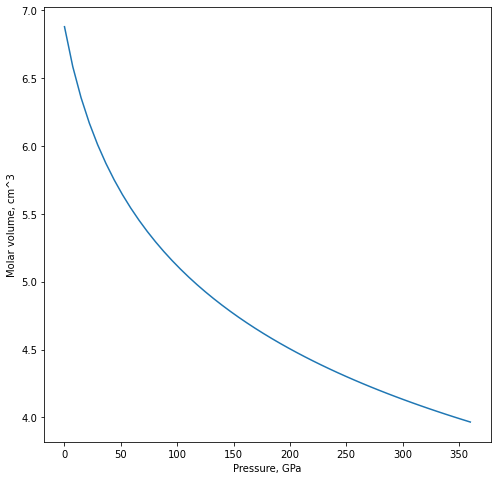

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_298)
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

In [6]:
def thermal_expansion(v, v0, a0, ag0, k):
    """
    Parameterisation of thermal expansion with pressure
    
    Uses Anderson-Gruneisen parameter. v is the volume
    of interest (i.e. at some pressure), v0 is the reference
    volume, a0 is the reference thermal expansivity, ag0
    is the 1 bar Anderson-Gruneisen parameter, k is a 
    dimensionless parameter.
    EQ5 of K14
    """
    a = a0 * np.exp(-1.0 * (ag0/k) * (1 - (v / v0)**k))
    return a


def expand_volume(v, t, v0, a0, ag0, k):
    """
    Calculate thermal expansion and apply to 'cold' volume
    """
    a = thermal_expansion(v, v0, a0, ag0, k)
    dt = t - 298.0 # How much hotter
    v_hot = v + (a * v * dt)
    return v_hot

In [7]:
v_5000 = expand_volume(v_298, 5000.0, 6.88, 9.0e-5, 5.1, 1.4)

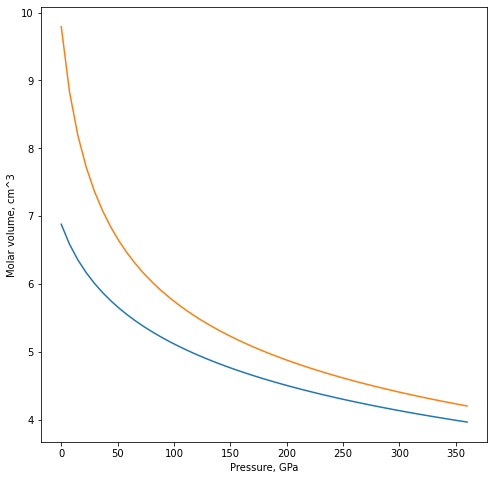

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_298)
ax.plot(ps, v_5000)
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

# End member free energy

Steps 1 and 4

In [9]:
def end_member_free_energy(p, t, gparams, v0, k0, kp, a0, ag0, k):
    num_points = 500
    ps = np.linspace(0.0, p, num_points) # in GPa
    vs = vinet_eos_volumes(ps, v0, k0, kp)
    vs = expand_volume(vs, t, v0, a0, ag0, k) # in cm^3/mol
    # Worry about units here??? GPa and cm^3?
    vdp = np.trapz(vs * 1.0E-6, ps * 1.0E9) # convert to m^3 and Pa -> J
    g_onebar = free_energy_onebar(t, gparams)
    g_pt = g_onebar + vdp
    return g_pt

def free_energy_onebar(t, prms):
    g_onebar = prms[0] + prms[1]*t + prms[2]*t*np.log(t) + \
               prms[3]*t**2.0 + prms[4]/t + prms[5]*t**(0.5)
    return g_onebar

In [10]:
params = [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0]
gpt = end_member_free_energy(300, 5000, params, 
                             6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)
print('Free energy of liquid Fe at 5000 K and 300 GPa is', gpt/1000.0, 'kJ/mol')


Free energy of liquid Fe at 5000 K and 300 GPa is 1167.540448797698 kJ/mol


## Ideal solution

Step 6 (for liquid)

In [11]:
def chemical_potential(x, p, t, gparams, v0, k0, kp, a0, ag0, k):
    mu_0 = end_member_free_energy(p, t, gparams, v0, k0, kp, a0, ag0, k)
    activity = x # ideal solution - could implement non-ideal here 
                 # but not good at ICB pressure
    r = 8.31446261815324 # gas constant J/K/mol
    mu = mu_0 + r * t * np.log(activity)
    return mu

def liquid_free_energy(x_fe, p, t):
    x_feo = 1.0 - x_fe
    
    # Presumably I need four chemical potentaisl to make up the liquid???
    
    fe_params = [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0]
    fe_v0 = 6.88
    fe_k0 = 148.0
    fe_kp = 5.8
    fe_a0 = 9.0e-5
    fe_ag0 = 5.1
    fe_k = 1.4
    
    if x_fe != 0.0:
        mu_fe = chemical_potential(x_fe, p, t, fe_params, fe_v0, fe_k0,
                                  fe_kp, fe_a0, fe_ag0, fe_k)
    
    feo_params = [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0]
    feo_v0 = 13.16
    feo_k0 = 128.0
    feo_kp = 3.85
    feo_a0 = 4.7e-5
    feo_ag0 = 4.5
    feo_k = 1.4
    
    if x_feo != 0.0:
        mu_feo = chemical_potential(x_feo, p, t, feo_params, feo_v0, feo_k0,
                                   feo_kp, feo_a0, feo_ag0, feo_k)
    
    if x_fe == 0.0:
        g = end_member_free_energy(p, t, feo_params, feo_v0, feo_k0,
                                   feo_kp, feo_a0, feo_ag0, feo_k)
    elif x_feo == 0.0:
        g = end_member_free_energy(p, t, fe_params, fe_v0, fe_k0,
                                   fe_kp, fe_a0, fe_ag0, fe_k)
    else:
        g = x_fe*mu_fe + x_feo*mu_feo

    return g


# Avoid hand coding loops. 
liquid_free_energies = np.vectorize(liquid_free_energy)

In [27]:
x_l = np.linspace(0.0, 1.0)
g_l_6000 = liquid_free_energies(x_l, 330, 6000)
g_l_5000 = liquid_free_energies(x_l, 330, 5000)
g_l_4000 = liquid_free_energies(x_l, 330, 4000)
g_l_3000 = liquid_free_energies(x_l, 330, 3000)

In [28]:
g_fe_6000 = end_member_free_energy(330, 6000, [12460.921, 386.99162, -52.2754, 0.000177578, -395355.43, -2476.28],
                                  6.753, 163.4, 5.38, 5.8E-5, 5.1, 1.4)
g_feo_6000 = end_member_free_energy(330, 6000, [-279318.0, 252.848, -46.12826, -0.0057402984, 0.0, 0.0],
                                  12.256, 149.0, 3.83, 4.5E-5, 4.25, 1.4)
g_solid_mixture_6000 = x_l*g_fe_6000 + (1.0 - x_l)*g_feo_6000


g_fe_5000 = end_member_free_energy(330, 5000, [12460.921, 386.99162, -52.2754, 0.000177578, -395355.43, -2476.28],
                                  6.753, 163.4, 5.38, 5.8E-5, 5.1, 1.4)
g_feo_5000 = end_member_free_energy(330, 5000, [-279318.0, 252.848, -46.12826, -0.0057402984, 0.0, 0.0],
                                  12.256, 149.0, 3.83, 4.5E-5, 4.25, 1.4)
g_solid_mixture_5000 = x_l*g_fe_5000 + (1.0 - x_l)*g_feo_5000


g_fe_4000 = end_member_free_energy(330, 4000, [12460.921, 386.99162, -52.2754, 0.000177578, -395355.43, -2476.28],
                                  6.753, 163.4, 5.38, 5.8E-5, 5.1, 1.4)
g_feo_4000 = end_member_free_energy(330, 4000, [-279318.0, 252.848, -46.12826, -0.0057402984, 0.0, 0.0],
                                  12.256, 149.0, 3.83, 4.5E-5, 4.25, 1.4)
g_solid_mixture_4000 = x_l*g_fe_4000 + (1.0 - x_l)*g_feo_4000


g_fe_3000 = end_member_free_energy(330, 3000, [12460.921, 386.99162, -52.2754, 0.000177578, -395355.43, -2476.28],
                                  6.753, 163.4, 5.38, 5.8E-5, 5.1, 1.4)
g_feo_3000 = end_member_free_energy(330, 3000, [-279318.0, 252.848, -46.12826, -0.0057402984, 0.0, 0.0],
                                  12.256, 149.0, 3.83, 4.5E-5, 4.25, 1.4)
g_solid_mixture_3000 = x_l*g_fe_3000 + (1.0 - x_l)*g_feo_3000

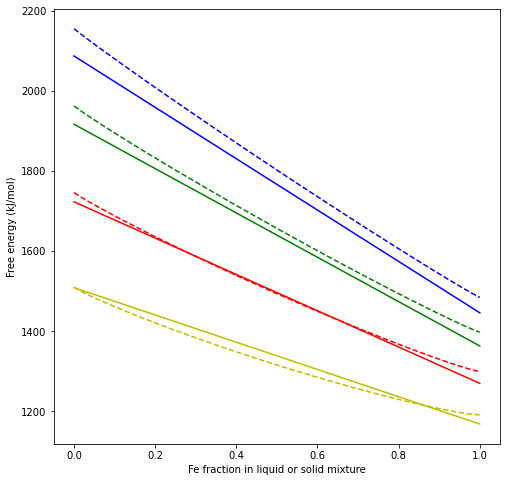

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x_l, g_l_6000/1000, 'y--')
ax.plot(x_l, g_l_5000/1000, 'r--')
ax.plot(x_l, g_l_4000/1000, 'g--')
ax.plot(x_l, g_l_3000/1000, 'b--')


ax.plot(x_l, g_solid_mixture_6000/1000, 'y-')
ax.plot(x_l, g_solid_mixture_5000/1000, 'r-')
ax.plot(x_l, g_solid_mixture_4000/1000, 'g-')
ax.plot(x_l, g_solid_mixture_3000/1000, 'b-')
ax.set_xlabel('Fe fraction in liquid or solid mixture')
ax.set_ylabel('Free energy (kJ/mol)')
plt.show()

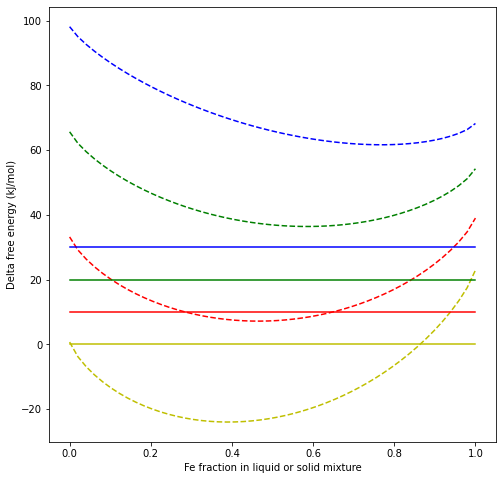

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x_l, (g_l_6000-g_solid_mixture_6000)/1000, 'y--')
ax.plot(x_l, (g_solid_mixture_6000-g_solid_mixture_6000)/1000, 'y-')

ax.plot(x_l, (g_l_5000-g_solid_mixture_5000)/1000 + 10.0, 'r--')
ax.plot(x_l, (g_solid_mixture_5000-g_solid_mixture_5000)/1000 + 10.0, 'r-')

ax.plot(x_l, (g_l_4000-g_solid_mixture_4000)/1000 + 20.0, 'g--')
ax.plot(x_l, (g_solid_mixture_4000-g_solid_mixture_4000)/1000 + 20.0, 'g-')

ax.plot(x_l, (g_l_3000-g_solid_mixture_3000)/1000 + 30.0, 'b--')
ax.plot(x_l, (g_solid_mixture_3000-g_solid_mixture_3000)/1000 + 30.0, 'b-')

ax.set_xlabel('Fe fraction in liquid or solid mixture')
ax.set_ylabel('Delta free energy (kJ/mol)')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

In [42]:
mu_fe_6000 = chemical_potential(x_l[1:], 330, 6000, [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0],
                                6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)
mu_fe_5000 = chemical_potential(x_l[1:], 330, 5000, [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0],
                                6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)
mu_fe_4000 = chemical_potential(x_l[1:], 330, 4000, [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0],
                                6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)
mu_fe_3000 = chemical_potential(x_l[1:], 330, 3000, [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0],
                                6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4)

mu_feo_6000 = chemical_potential(1.0-x_l[:-1], 330, 6000, [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0],
                                13.16, 128.0, 3.85, 4.7e-5, 4.5, 1.4)
mu_feo_5000 = chemical_potential(1.0-x_l[:-1], 330, 5000, [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0],
                                13.16, 128.0, 3.85, 4.7e-5, 4.5, 1.4)
mu_feo_4000 = chemical_potential(1.0-x_l[:-1], 330, 4000, [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0],
                                13.16, 128.0, 3.85, 4.7e-5, 4.5, 1.4)
mu_feo_3000 = chemical_potential(1.0-x_l[:-1], 330, 3000, [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0],
                                13.16, 128.0, 3.85, 4.7e-5, 4.5, 1.4)

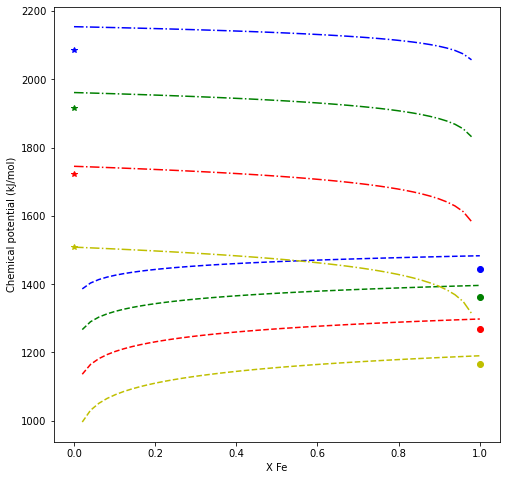

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x_l[1:], mu_fe_6000/1000, 'y--')
ax.plot(x_l[1:], mu_fe_5000/1000, 'r--')
ax.plot(x_l[1:], mu_fe_4000/1000, 'g--')
ax.plot(x_l[1:], mu_fe_3000/1000, 'b--')


ax.plot(x_l[:-1], mu_feo_6000/1000, 'y-.')
ax.plot(x_l[:-1], mu_feo_5000/1000, 'r-.')
ax.plot(x_l[:-1], mu_feo_4000/1000, 'g-.')
ax.plot(x_l[:-1], mu_feo_3000/1000, 'b-.')


ax.plot(1.0, g_fe_6000/1000, 'yo')
ax.plot(0.0, g_feo_6000/1000, 'y*')

ax.plot(1.0, g_fe_5000/1000, 'ro')
ax.plot(0.0, g_feo_5000/1000, 'r*')

ax.plot(1.0, g_fe_4000/1000, 'go')
ax.plot(0.0, g_feo_4000/1000, 'g*')

ax.plot(1.0, g_fe_3000/1000, 'bo')
ax.plot(0.0, g_feo_3000/1000, 'b*')

ax.set_xlabel('X Fe')
ax.set_ylabel('Chemical potential (kJ/mol)')
plt.show()

In [79]:
def _delta_mu_fe_liquid(x, p, t, gsolid):
    mu_fe_liquid = chemical_potential(x, p, t, [-9007.3402, 290.29866, -46.0, 0.0, 0.0, 0.0],
                                      6.88, 148.0, 5.8, 9.0e-5, 5.1, 1.4) 
    delta_mu = mu_fe_liquid - gsolid
    return delta_mu

def _delta_mu_feo_liquid(x, p, t, gsolid):
    mu_feo_liquid = chemical_potential(1.0-x, p, t, [-245310.0, 231.879, -46.12826, -0.0057402984, 0.0, 0.0],
                                       13.16, 128.0, 3.85, 4.7e-5, 4.5, 1.4) 
    delta_mu = mu_feo_liquid - gsolid
    return delta_mu
    

def find_liquidus(p, t):
    """
    At some Ps and Ts we should have two liquidus compositions 
    (one on each side of the eutectic). These are the compositions
    for the liquid where mu_liquid == mu_solid for Fe or FeO, 
    respectivly
    """
    # Solids
    g_fe_solid = end_member_free_energy(p, t, [12460.921, 386.99162, -52.2754, 0.000177578, -395355.43, -2476.28],
                                        6.753, 163.4, 5.38, 5.8E-5, 5.1, 1.4)
    g_feo_solid = end_member_free_energy(p, t, [-279318.0, 252.848, -46.12826, -0.0057402984, 0.0, 0.0],
                                         12.256, 149.0, 3.83, 4.5E-5, 4.25, 1.4)
    
    x_fe_side = spo.brentq(_delta_mu_fe_liquid, 0.000000001, 1.0, args=(p, t, g_fe_solid))
    x_feo_side = spo.brentq(_delta_mu_feo_liquid, 0.0, 0.999999999, args=(p, t, g_feo_solid))
    return x_fe_side , x_feo_side



In [98]:
p1 = 330.0
p2 = 220.0
ts = np.linspace(3500, 5000)
x11 = np.zeros_like(ts)
x21 = np.zeros_like(ts)
x12 = np.zeros_like(ts)
x22 = np.zeros_like(ts)

for i, t in enumerate(ts):
    x11[i], x21[i] = find_liquidus(p1, t)
    x12[i], x22[i] = find_liquidus(p2, t)

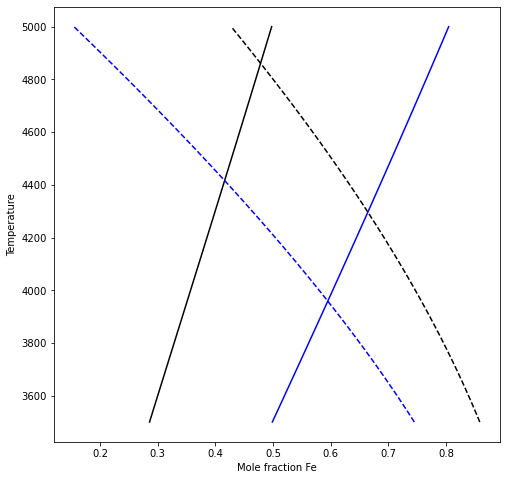

In [99]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x11, ts, 'k')
ax.plot(x21, ts, 'k--')

ax.plot(x12, ts, 'b')
ax.plot(x22, ts, 'b--')

ax.set_xlabel('Mole fraction Fe')
ax.set_ylabel('Temperature')
plt.show()